# About Vehicle Control

- Spawn multiple vehicles in MetaDriveEnv
  - generate_ts and recycle_ts controls the timestep they appear and disappear
  - position is a 2d coordinate, (0,0) is the left corner(starting point of ego car) of the top-down map
  - heading is direction in radians(0 to $2\pi$)
  - Existing keys of vehicle_config: 
  ```dict_keys(['max_steering', 'max_engine_force', 'max_speed_km_h', 'max_brake_force', 'wheel_friction', 'vehicle_model', 'enable_reverse', 'show_navi_mark', 'show_dest_mark', 'show_line_to_dest', 'show_line_to_navi_mark', 'use_special_color', 'no_wheel_friction', 'image_source', 'navigation_module', 'spawn_lane_index', 'destination', 'spawn_longitude', 'spawn_lateral', 'spawn_position_heading', 'spawn_velocity', 'spawn_velocity_car_frame', 'overtake_stat', 'random_color', 'width', 'length', 'height', 'mass', 'top_down_width', 'top_down_length', 'lidar', 'side_detector', 'lane_line_detector', 'show_lidar', 'show_side_detector', 'show_lane_line_detector', 'light', 'norm_pixel', 'random_agent_model']).``` 

In [ ]:
from metadrive.envs import MetaDriveEnv
from metadrive.manager import BaseManager
from metadrive.component.vehicle.vehicle_type import DefaultVehicle,XLVehicle
from IPython.display import clear_output, Image
from metadrive.policy.idm_policy import IDMPolicy

class ExampleManager(BaseManager):
    def __init__(self):
        super(ExampleManager, self).__init__()
        self.generated_v = None
        self.generate_ts = 15
        self.recycle_ts = 100
        
    def before_step(self):
        if self.generated_v:
            self.generated_v.before_step([0, 1]) # set action for v
            self.generated_v2.before_step([0, 1]) # set action for v2
        
    def after_step(self):
        if self.episode_step == self.generate_ts:
            self.generated_v = self.spawn_object(XLVehicle,    # spawn a xl size vehicle
                                  vehicle_config=(dict(max_speed_km_h=20)), 
                                  position=(60,20), 
                                  heading=4.7,
                                  )
            self.generated_v2 = self.spawn_object(DefaultVehicle,  # spawn a default size vehicle
                                  vehicle_config=dict(), 
                                  position=(0, 0), 
                                  heading=0)
        elif self.episode_step == self.recycle_ts:
            self.clear_objects([self.generated_v.id])
            self.generated_v = None
        elif self.generated_v:
            self.generated_v.after_step()

class ExampleEnv(MetaDriveEnv):

    def setup_engine(self):
        super(ExampleEnv, self).setup_engine()
        self.engine.register_manager("exp_mgr", ExampleManager())

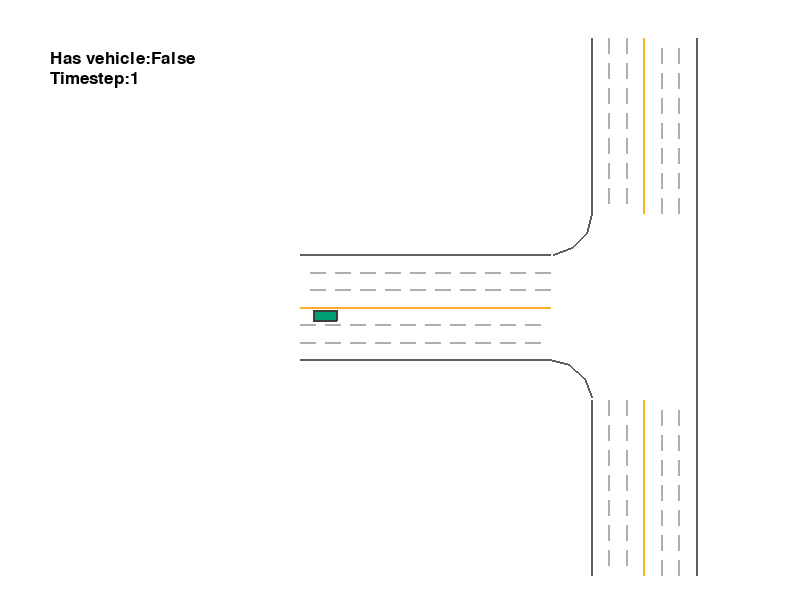

In [3]:
env = ExampleEnv(dict(map="T",
                      agent_policy=IDMPolicy,
                      traffic_density=0.0,))
# Ensure you have a generated vehicle in the environment
env.reset()
print("lane num is ", env.current_map.config["lane_num"])

try:
    env.reset()
    for _ in range(120):
        env.step([0, 1]) 
        env.render(mode="topdown", 
                   window=False,
                   screen_size=(800, 600),
                   camera_position=(20, 10),
                   screen_record=True,
                   text={"Has vehicle": env.engine.managers["exp_mgr"].generated_v is not None,
                         "Timestep": env.episode_step})
    env.top_down_renderer.generate_gif()
finally:
    env.close()
    clear_output()
Image(open("demo.gif", 'rb').read())

- How to control the type of generated vehicle, such as truck, suv, sedan?
  - Answer: check vehicle type metadrive/component/vehicle/vehicle_type.py
- How to generate a vehicle and control it with IDMPolicy? Furthermore, First control it with input action [0,1] and let IDMPolicy take over after 10 timesteps. 


- How to control the ego car with IDMPolicy at certain points? Eg. First control the ego car by action [0,1], and when it reaches 10 timesteps, let IDMPolicy take over?